<a href="https://colab.research.google.com/github/Kudzo90/BigMart-Sales-Prediction/blob/main/Sales_prediction_using_NN_EKPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
%matplotlib inline

In [30]:
#Loading datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [31]:
# Eyeballing the data
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 1. Data Preprocessing

In [32]:
# Checking the shape of the datasets
print(df_train.shape, df_test.shape)

(8523, 12) (5681, 11)


We see that there are 12 features and over 8500 records in the train dataset and under 6000 records in the test dataset

In [33]:
# Checking data types
print(df_train.dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


In [34]:
# Checking for missing values
df_train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


There are missing values in the train data, specifically, in the _"Item_Weight"_ and _"Outlet_Size."_
I'll address these next

### Handling Missing Values:
Using Mode for Categorical variables

In [35]:
# Handling missing values
# Identify the categorical variables
categorical_variables = []
for column in df_train.columns:
    if df_train[column].dtype == "object":
        categorical_variables.append(column)

# Replace missing values with the mode
for column in categorical_variables:
    # For categorical variables
    df_train[column] = df_train[column].fillna(df_train[column].mode()[0])


# Handling missing values in numerical variables
# Identify the numerical variables
numerical_variables = []
for column in df_train.columns:
    if df_train[column].dtype != "object":
        numerical_variables.append(column)

# Replace missing values with the median
for column in numerical_variables:
    # For numerical variables
    df_train[column] = df_train[column].fillna(df_train[column].median())

# Checking
df_train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [36]:
# creating a broad category of type of Items
df_train['Item_Type_Combined'] = df_train['Item_Identifier'].apply(lambda df_train: df_train[0:2])
df_train['Item_Type_Combined'] = df_train['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
df_train['Item_Type_Combined'].value_counts()

,count
Item_Type_Combined,
Food,6125
Non-Consumable,1599
Drinks,799


In [37]:
# Removing all whitespaces and other characters
cat_columns = df_train.select_dtypes('object').columns
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: x.str.replace(' ', '_'))

# Dealing with categorical variables

In [38]:
# Let's look at the unique categories in each variable
# Checking unique categories in each variable

unique_categories_df = pd.DataFrame(columns=["Column name", "Unique categories"])

# Populate the DataFrame
for column in categorical_variables:
    unique_categories_df.loc[len(unique_categories_df)] = [column, df_train[column].unique()]

# Print the DataFrame
unique_categories_df

,Column name,Unique categories
0,Item_Identifier,"[FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO..."
1,Item_Fat_Content,"[Low_Fat, Regular, low_fat, LF, reg]"
2,Item_Type,"[Dairy, Soft_Drinks, Meat, Fruits_and_Vegetabl..."
3,Outlet_Identifier,"[OUT049, OUT018, OUT010, OUT013, OUT027, OUT04..."
4,Outlet_Size,"[Medium, High, Small]"
5,Outlet_Location_Type,"[Tier_1, Tier_3, Tier_2]"
6,Outlet_Type,"[Supermarket_Type1, Supermarket_Type2, Grocery..."


From the above result, we see that the _Item_Fat_Content_ has more than two categories. But in fact, there are only 2. I'll change all to be either Low or Regular.
Again, we see that only the _Item_Fat_Content_ and _Outlet_Size_ have inherent order. The rest anr just categories.
Beacuase of this, I'll use **LabelEncoding** for these two variables and use **One-hot Enconding** for the rest.

In [39]:
# Define a mapping dictionary to standardize the fat content values
fat_content_mapping = {
    'Low_Fat': 'Low',
    'Regular': 'Regular',
    'low_fat': 'Low',
    'LF': 'Low',
    'reg': 'Regular'
}

# Apply the mapping to standardize the fat content values
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].map(fat_content_mapping)
df_train['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low,5517
Regular,3006


In [40]:
from sklearn.preprocessing import LabelEncoder
# label encoding the ordinal variables
le = LabelEncoder()
df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df_train[i] = le.fit_transform(df_train[i])


# one hot encoding the remaining categorical variables
df_train = pd.get_dummies(df_train, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

Since the Variable _Outlet_Establishment_Year_ may not mean a lot to us, I'll derive a more useful feature from it.
I'll create a new feature called _Outlet_Age_ to tell us how old each outlet is.

In [41]:
# Creating the Outlet age
# Get the current year
import datetime
#current_year = datetime.datetime.now().year

# Derive the age of the outlet
df_train['Outlet_Age'] = 2013 - df_train['Outlet_Establishment_Year']


Before I continue, I will drop both identifiers in the dataset

In [42]:
# dropping the ID variables and variables that have been used to extract new variables
df_train.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier'],axis=1,inplace=True)


#df_train.head()


In [43]:
df_processed = df_train.copy()
df_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,...,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9,Outlet_Age
0,9.30,0.016047,249.8092,3735.1380,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,14
1,5.92,0.019278,48.2692,443.4228,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,4
2,17.50,0.016760,141.6180,2097.2700,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,14
3,19.20,0.000000,182.0950,732.3800,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,15
4,8.93,0.000000,53.8614,994.7052,True,False,False,False,True,True,...,True,False,False,False,False,False,False,False,False,26


In [44]:
df_processed.isna().sum()

,0
Item_Weight,0
Item_Visibility,0
Item_MRP,0
Item_Outlet_Sales,0
Item_Fat_Content_0,0
Item_Fat_Content_1,0
Outlet_Location_Type_0,0
Outlet_Location_Type_1,0
Outlet_Location_Type_2,0
Outlet_Size_0,0


In [55]:
# Save the processed dataset
df_processed.to_csv("df_processed.csv", index=False)

In [45]:
from sklearn.preprocessing import StandardScaler # Standardize the numerical variables

# Split the data into features and target
X = df_processed.drop('Item_Outlet_Sales', axis=1)
y = df_processed['Item_Outlet_Sales']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#transform the target variable for training
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


# Create a StandardScaler for features and target variable
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the training data and transform both features and target variable
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform the test data using the fitted scalers
X_test_scaled = scaler_x.transform(X_test)


### 2. Deep Learning

Defining the architecture of the model

In [46]:
import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, InputLayer
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 25.2466 - mae: 4.3829 - val_loss: 3.0280 - val_mae: 1.5941 - learning_rate: 0.0010
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1386 - mae: 1.1680 - val_loss: 0.5263 - val_mae: 0.5878 - learning_rate: 0.0010
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4976 - mae: 0.9736 - val_loss: 0.4128 - val_mae: 0.5050 - learning_rate: 0.0010
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2384 - mae: 0.8897 - val_loss: 0.3485 - val_mae: 0.4675 - learning_rate: 0.0010
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1464 - mae: 0.8571 - val_loss: 0.3757 - val_mae: 0.4897 - learning_rate: 0.0010
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0455 - mae: 0.8121 - val_loss: 0.3587 - val_mae: 0.4782 - learning_rate: 0.0010
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0195 - mae: 0.8058 - val_loss: 0.3545 - val_mae: 0.4777 - learning_rate: 0.00

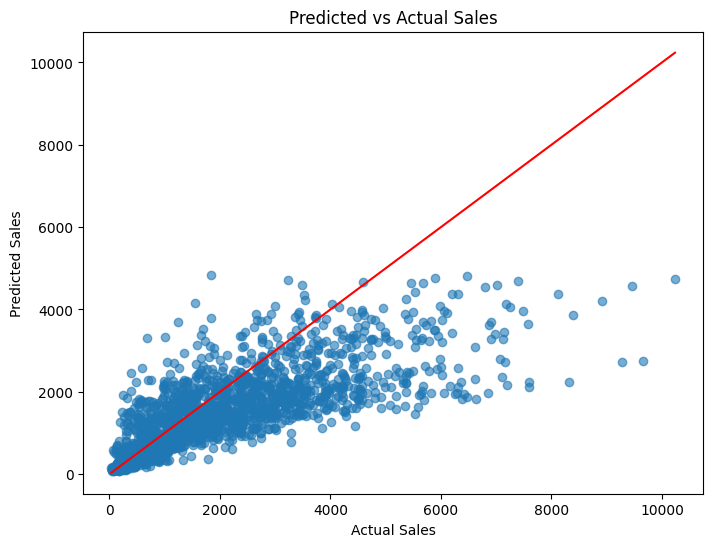

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# 2. Load and Preprocess Data
# -----------------------------
# Load the df_processed csv file
#df_processed = pd.read_csv('df_processed.csv')
X = df_processed.drop('Item_Outlet_Sales', axis=1)
y = df_processed['Item_Outlet_Sales']

# Log-transform target
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# -----------------------------
# 3. Build Neural Network
# -----------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

# -----------------------------
# 4. Callbacks for Optimization
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# -----------------------------
# 5. Train Model
# -----------------------------
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# -----------------------------
# 6. Evaluate Model
# -----------------------------
predictions_log = model.predict(X_test_scaled).flatten()
predictions = np.expm1(predictions_log)  # Inverse log transform
y_test_original = np.expm1(y_test)

# Metrics
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# -----------------------------
# 7. Visualization
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test_original, predictions, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], color='red')
plt.show()

### SAVE MODELS

In [48]:
# -----------------------------
# 8. Save Model for Deployment
# -----------------------------
#model.save("bigmart_sales_model.h5")  # Save in HDF5 format
model.save('NN_model.keras')
# To load later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model("bigmart_sales_model.h5")

# -----------------------------
# 9. Save Predictions
# -----------------------------
results_df = pd.DataFrame({
    'Actual_Sales': y_test_original,
    'Predicted_Sales': predictions
})

results_df.to_csv("bigmart_predictions.csv", index=False)
print("Model and predictions saved successfully!")

Model and predictions saved successfully!


### New TRY

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [50]:
# Define the hyperparameters to search over
# param_grid = {
#     'hidden_layer_sizes': [(20,), (30,), (50,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['adam'],
#     'alpha': [0.0001, 0.001, 0.05],
#     'learning_rate': ['constant','adaptive'],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 500]
# }

param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001],
    'max_iter': [300]
}


In [51]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1)

In [52]:
# # Create an MLP regressor object
# model = MLPRegressor(random_state=42)

# # Create a grid search object
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

# # Fit the grid search to the training data
# grid_search.fit(X_train_scaled, y_train_log)

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# -----------------------------
# 1. Define Model
# -----------------------------
model = MLPRegressor(random_state=42, early_stopping=True)

# -----------------------------
# 2. Define Parameter Distributions
# -----------------------------
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300, 500]
}

# -----------------------------
# 3. Randomized Search
# -----------------------------
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,            # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,            # Use all cores for parallel processing
    random_state=42,
    verbose=2
)

# -----------------------------
# 4. Fit the Randomized Search
# -----------------------------
random_search.fit(X_train_scaled, y_train_log)

# -----------------------------
# 5. Best Parameters & Model
# -----------------------------
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# -----------------------------
# 6. Evaluate on Test Set
# -----------------------------
predictions_log = best_model.predict(X_test_scaled)
predictions = np.expm1(predictions_log)
y_test_original = np.expm1(y_test)

mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh'}
Test MSE: 1116431.50
Test RMSE: 1056.61


### IMPROVEMENTS

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Performance Comparison:
          Model           MSE         RMSE        R²
0  Improved NN  1.207398e+06  1098.816622  0.555772
1      XGBoost  1.117793e+06  1057.257390  0.588740
2     Ensemble  1.145670e+06  1070.359914  0.578483


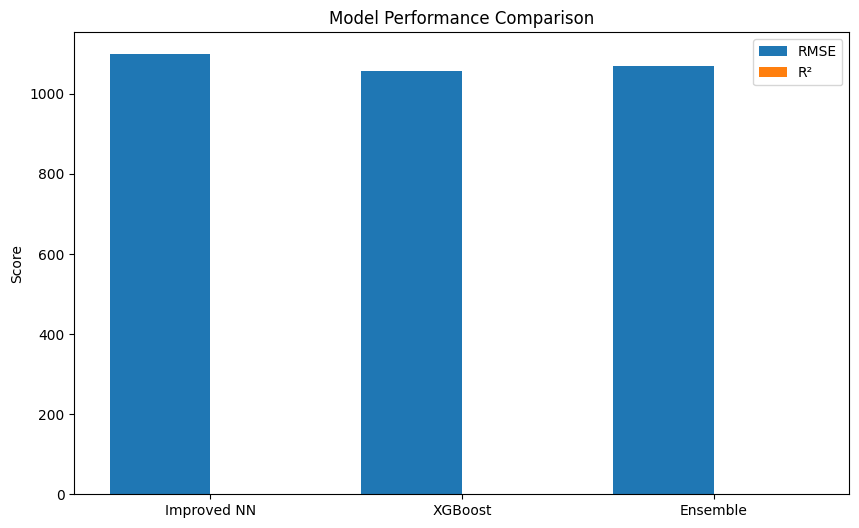


✅ Best performing model based on RMSE: XGBoost


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# -----------------------------
# 1. Load Preprocessed Data
# -----------------------------
# If you already have df_processed in memory, skip this line
df_processed = pd.read_csv('df_processed.csv')  # Ensure this file exists
X = df_processed.drop('Item_Outlet_Sales', axis=1)
y = df_processed['Item_Outlet_Sales']

# Log-transform target
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# -----------------------------
# 2. Option 1: Improved Neural Network
# -----------------------------
nn_model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32,
                        callbacks=[early_stop, reduce_lr], verbose=0)

nn_preds_log = nn_model.predict(X_test_scaled).flatten()
nn_preds = np.expm1(nn_preds_log)
y_test_original = np.expm1(y_test)

nn_mse = mean_squared_error(y_test_original, nn_preds)
nn_rmse = np.sqrt(nn_mse)
nn_r2 = r2_score(y_test_original, nn_preds)

# -----------------------------
# 3. Option 2: XGBoost Model
# -----------------------------
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error',
                                    cv=5, n_jobs=-1, random_state=42, verbose=0)
random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_
xgb_preds_log = best_xgb.predict(X_test_scaled)
xgb_preds = np.expm1(xgb_preds_log)

xgb_mse = mean_squared_error(y_test_original, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test_original, xgb_preds)

# -----------------------------
# 4. Option 3: Ensemble (Average of NN and XGB)
# -----------------------------
ensemble_preds = (nn_preds + xgb_preds) / 2
ensemble_mse = mean_squared_error(y_test_original, ensemble_preds)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test_original, ensemble_preds)

# -----------------------------
# 5. Comparison and Visualization
# -----------------------------
results = pd.DataFrame({
    'Model': ['Improved NN', 'XGBoost', 'Ensemble'],
    'MSE': [nn_mse, xgb_mse, ensemble_mse],
    'RMSE': [nn_rmse, xgb_rmse, ensemble_rmse],
    'R²': [nn_r2, xgb_r2, ensemble_r2]
})

print("\nPerformance Comparison:\n", results)

# Plot comparison
plt.figure(figsize=(10,6))
x = np.arange(len(results['Model']))
plt.bar(x-0.2, results['RMSE'], width=0.4, label='RMSE')
plt.bar(x+0.2, results['R²'], width=0.4, label='R²')
plt.xticks(x, results['Model'])
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

# -----------------------------
# 6. Decision Explanation
# -----------------------------
best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
print(f"\n✅ Best performing model based on RMSE: {best_model_name}")

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 19.7182 - mae: 3.4760 - val_loss: 3.7960 - val_mae: 1.7538 - learning_rate: 0.0010
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3269 - mae: 0.7994 - val_loss: 0.6442 - val_mae: 0.4486 - learning_rate: 0.0010
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1345 - mae: 0.7203 - val_loss: 0.7201 - val_mae: 0.4903 - learning_rate: 0.0010
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0331 - mae: 0.6801 - val_loss: 0.7476 - val_mae: 0.5101 - learning_rate: 0.0010
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0080 - mae: 0.6621 - val_loss: 0.6796 - val_mae: 0.4616 - learning_rate: 0.0010
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9358 - mae: 0.6369 - val_loss: 0.6580 - val_mae: 0.4597 - learning_rate: 0.0010
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9086 - mae: 0.6239 - val_loss: 0.6416 - val_mae: 0.4514 - learning_rate: 0.0010
Epoch 8/2

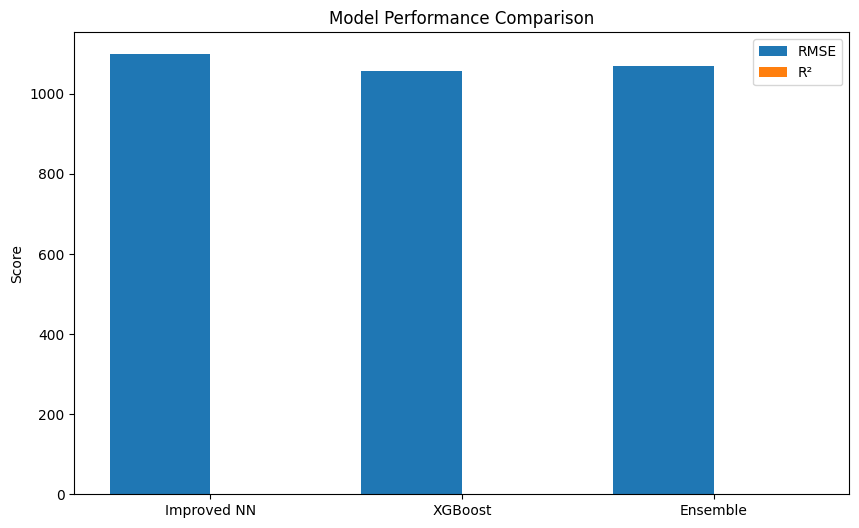


✅ Best performing model based on RMSE: XGBoost


In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from joblib import dump

# -----------------------------
# 1. Load Preprocessed Data
# -----------------------------
df_processed = pd.read_csv('df_processed.csv')  # Ensure this file exists
X = df_processed.drop('Item_Outlet_Sales', axis=1)
y = df_processed['Item_Outlet_Sales']

# Log-transform target
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# -----------------------------
# 2. Improved Neural Network
# -----------------------------
nn_model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32,
             callbacks=[early_stop, reduce_lr], verbose=1)

nn_preds_log = nn_model.predict(X_test_scaled).flatten()
nn_preds = np.expm1(nn_preds_log)
y_test_original = np.expm1(y_test)

nn_mse = mean_squared_error(y_test_original, nn_preds)
nn_rmse = np.sqrt(nn_mse)
nn_r2 = r2_score(y_test_original, nn_preds)

# Save NN model and predictions
nn_model.save('improved_nn_model.keras')
pd.DataFrame({'Actual': y_test_original, 'Predicted': nn_preds}).to_csv('nn_predictions.csv', index=False)

# -----------------------------
# 3. XGBoost Model
# -----------------------------
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20,
                                    scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

best_xgb = random_search.best_estimator_
xgb_preds_log = best_xgb.predict(X_test_scaled)
xgb_preds = np.expm1(xgb_preds_log)

xgb_mse = mean_squared_error(y_test_original, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test_original, xgb_preds)

# Save XGBoost model and predictions
dump(best_xgb, 'xgboost_model.joblib')
pd.DataFrame({'Actual': y_test_original, 'Predicted': xgb_preds}).to_csv('xgb_predictions.csv', index=False)

# -----------------------------
# 4. Ensemble
# -----------------------------
ensemble_preds = (nn_preds + xgb_preds) / 2
ensemble_mse = mean_squared_error(y_test_original, ensemble_preds)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test_original, ensemble_preds)

pd.DataFrame({'Actual': y_test_original, 'Predicted': ensemble_preds}).to_csv('ensemble_predictions.csv', index=False)

# -----------------------------
# 5. Print Comparison
# -----------------------------
print("\nPerformance Comparison:")
print(f"Improved NN -> MSE: {nn_mse:.2f}, RMSE: {nn_rmse:.2f}, R²: {nn_r2:.4f}")
print(f"XGBoost     -> MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")
print(f"Ensemble    -> MSE: {ensemble_mse:.2f}, RMSE: {ensemble_rmse:.2f}, R²: {ensemble_r2:.4f}")

# Plot comparison
plt.figure(figsize=(10,6))
x = np.arange(len(results['Model']))
plt.bar(x-0.2, results['RMSE'], width=0.4, label='RMSE')
plt.bar(x+0.2, results['R²'], width=0.4, label='R²')
plt.xticks(x, results['Model'])
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

# -----------------------------
# 6. Decision Explanation
# -----------------------------
best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
print(f"\n✅ Best performing model based on RMSE: {best_model_name}")